# Введение в искусственные нейронные сети

## Курсовая работа. Задание 1

__Обучите нейронную сеть любой архитектуры которой не было на курсе, либо обучите нейронную сеть разобранной архитектуры, но на том датасете, которого не было на уроках. Сделайте анализ, того, что вам помогло в улучшения работы нейронной сети.__

## Будем предсказывать дневную цену закрытия акций Газпрома (тикер 'OGZPY' на OTC US) на основе 10-летнего временного ряда##

In [1]:
import pandas as pd
import numpy as np
import pandas.util.testing as tm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline
from pandas_datareader.data import DataReader

from datetime import datetime

from tensorflow.keras import utils
from keras.optimizers import Adam
from keras.models import Sequential, Model
from keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM

from sklearn.preprocessing import StandardScaler, MinMaxScaler
#from tensorflow.keras.callbacks import EarlyStopping

from google.colab import files

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  This is separate from the ipykernel package so we can avoid doing imports until
Using TensorFlow backend.


In [2]:
# получение датафрейма цен на акции ГП
df = DataReader('OGZPY', data_source='yahoo', start='2010-07-01', end=datetime.now())
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-07-01,9.375,9.160,9.345,9.225,2430000.0,4.493232
2010-07-02,9.535,9.420,9.465,9.525,160000.0,4.639354
2010-07-06,9.875,9.650,9.775,9.675,487400.0,4.712414
2010-07-07,10.000,9.690,9.715,10.000,1300800.0,4.870713
2010-07-08,9.975,9.805,9.915,9.950,307800.0,4.846360
...,...,...,...,...,...,...
2020-07-20,5.250,5.200,5.210,5.250,181300.0,5.250000
2020-07-21,5.310,5.250,5.250,5.260,365900.0,5.260000
2020-07-22,5.290,5.230,5.290,5.240,180900.0,5.240000


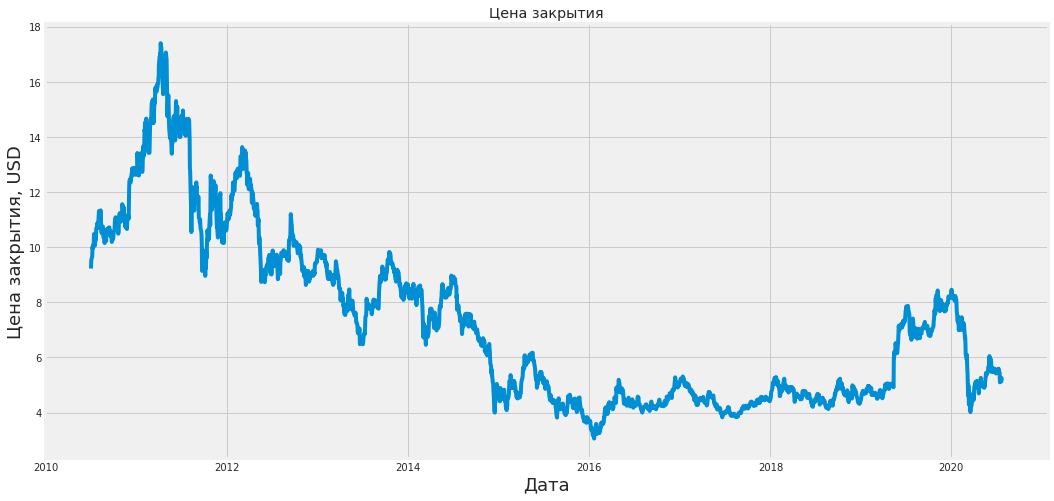

In [3]:
plt.figure(figsize=(16,8))
plt.title('Цена закрытия')
plt.plot(df['Close'])
plt.xlabel('Дата', fontsize=18)
plt.ylabel('Цена закрытия, USD', fontsize=18)
plt.show()

In [4]:
# Создаем новый df, оставляя только колонку close/закрытие
data = df.filter(['Close'])

# конвертация df в массив numpy
dataset = data.values

# выпиливыем тренировочный датасет
training_data_len = int(np.ceil( len(dataset) * .8 ))

training_data_len

2028

In [5]:
# нормализация данных, чтобы градиент не свихнулся по дороге к успеху

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.42991636],
       [0.45083681],
       [0.4612971 ],
       ...,
       [0.15202231],
       [0.14574618],
       [0.14644351]])

In [6]:
# нормализация тренировочного датасета

train_data = scaled_data[0:int(training_data_len), :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 66:
        print(x_train)
        print(y_train)
        print()

[array([0.42991636, 0.45083681, 0.4612971 , 0.48396096, 0.4804742 ,
       0.48919108, 0.49093449, 0.51708512, 0.50662483, 0.5153417 ,
       0.48744773, 0.50139472, 0.50662483, 0.50418411, 0.53103211,
       0.53103211, 0.53626222, 0.54532778, 0.53242677, 0.54672244,
       0.53974898, 0.57496517, 0.56729428, 0.57461649, 0.56450488,
       0.56764296, 0.5770572 , 0.56938638, 0.525802  , 0.52440726,
       0.51952583, 0.53103211, 0.53556485, 0.53626222, 0.52196655,
       0.51011159, 0.50557885, 0.4961646 , 0.49442119, 0.49790795,
       0.51115764, 0.50313806, 0.49965137, 0.52231523, 0.52894008,
       0.52510463, 0.51708512, 0.52510463, 0.53242677, 0.53172947,
       0.53417019, 0.52405858, 0.525802  , 0.5153417 , 0.51185494,
       0.5237099 , 0.51882847, 0.50627614, 0.49721059, 0.50418411])]
[0.5031380640790015]

[array([0.42991636, 0.45083681, 0.4612971 , 0.48396096, 0.4804742 ,
       0.48919108, 0.49093449, 0.51708512, 0.50662483, 0.5153417 ,
       0.48744773, 0.50139472, 0.506

In [7]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [8]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(1968, 60, 1)

In [9]:
# строим модель LSTM

model = Sequential()
model.add(LSTM(32, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences= True))
model.add(Conv1D(10, 5, activation="linear"))
model.add(Conv1D(10, 5, activation="linear"))
model.add(Flatten())
model.add(Dense(5, activation='linear'))
model.add(Dense(1, activation='linear'))

model.compile(loss="mse", optimizer="adam", metrics=['mae'])
model.fit(x_train, y_train, batch_size=30, epochs=50, verbose = 1)

Epoch 1/50
1968/1968 [==============================] - 5s 3ms/step - loss: 0.0086 - mae: 0.0623
Epoch 2/50
1968/1968 [==============================] - 4s 2ms/step - loss: 0.0028 - mae: 0.0373
Epoch 3/50
1968/1968 [==============================] - 4s 2ms/step - loss: 0.0022 - mae: 0.0328
Epoch 4/50
1968/1968 [==============================] - 4s 2ms/step - loss: 0.0016 - mae: 0.0282
Epoch 5/50
1968/1968 [==============================] - 4s 2ms/step - loss: 0.0016 - mae: 0.0280
Epoch 6/50
1968/1968 [==============================] - 4s 2ms/step - loss: 0.0013 - mae: 0.0259
Epoch 7/50
1968/1968 [==============================] - 4s 2ms/step - loss: 0.0015 - mae: 0.0270
Epoch 8/50
1968/1968 [==============================] - 5s 2ms/step - loss: 0.0013 - mae: 0.0258
Epoch 9/50
1968/1968 [==============================] - 4s 2ms/step - loss: 0.0010 - mae: 0.0229
Epoch 10/50
1968/1968 [==============================] - 5s 2ms/step - loss: 0.0012 - mae: 0.0244
Epoch 11/50
1968/1968 [======

In [12]:
# создаем тестовый датасет

test_data = scaled_data[training_data_len - 60: , :]

x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

In [13]:
x_test = np.array(x_test)

In [14]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

In [15]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [16]:
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

0.21953593357570103

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


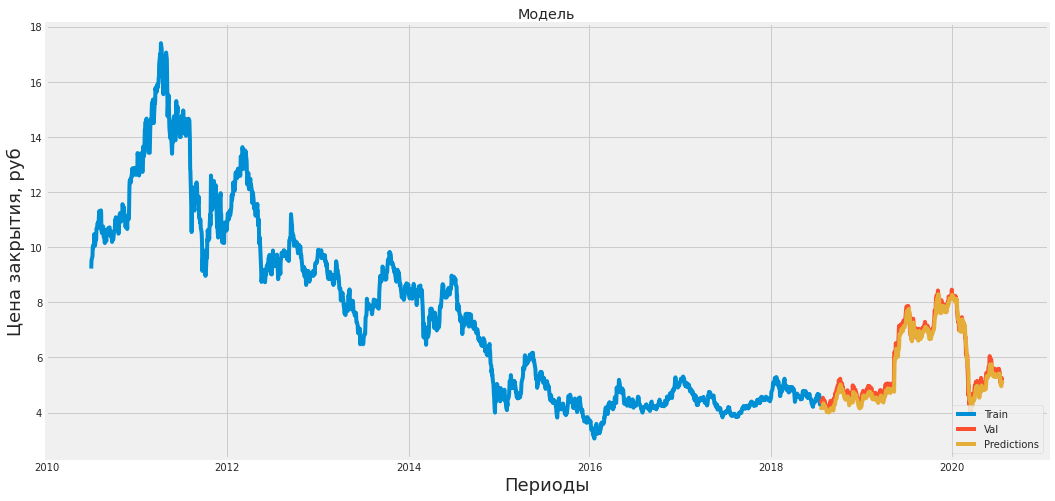

In [17]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(16,8))
plt.title('Модель')
plt.xlabel('Периоды', fontsize=18)
plt.ylabel('Цена закрытия, руб', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [18]:
valid

,Close,Predictions
Date,,
2018-07-23,4.37,4.103445
2018-07-24,4.37,4.150824
2018-07-25,4.42,4.184979
2018-07-26,4.36,4.186280
2018-07-27,4.37,4.175866
...,...,...
2020-07-20,5.25,4.957437
2020-07-21,5.26,5.035564
2020-07-22,5.24,5.100699


## Анализ:
1. Результат хороший
2. Среднеквадратичная ошибка приемлемая
3. Переработал код из методички, немного упростив, в результате чего сеть стала работать намного шустрее
4. Смотрел несколько сценариев, эксперементируя с глубиной и шириной сети:<br>
a. Сначала менял параметры по одному, потом - в комплексе, оценивая силу воздействия каждого<br>
b. Оптимизировал количество слоев (между 2-мя и 4-мя; оставил 2)<br>
c. Эксперементировал с количеством ядер в каждом слое то наращивая, то уменьшая, то делая равным во всех слоях; в итоге оставил равным 32 в первом и 64 во втором<br>
d. Подбирал batch size и количество эпох; остановился на 30 и 10 соответственно<br>
e. Менял sequence generation; остановился на 60<br>
5. Примечательно, что прогнозные цены немного меньше реальных; в мире финансов это хорошо, т.к. обеспечивается консервативный подход.